## Imports

In [110]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [111]:
%%time

import utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,RandomizedSearchCV, KFold,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from xgboost import plot_tree
from sklearn import tree
import shap

import warnings
warnings.filterwarnings('ignore')

%watermark -v -m -p numpy,pandas,matplotlib,seaborn,sklearn,xgboost,shap

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

numpy     : 1.26.2
pandas    : 2.1.3
matplotlib: 3.8.2
seaborn   : 0.13.0
sklearn   : 1.3.2
xgboost   : 2.0.2
shap      : 0.43.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

CPU times: user 5.32 ms, sys: 9.49 ms, total: 14.8 ms
Wall time: 29.6 ms


# Experiment 1 (Diagnostic model)

## Data preprocessing

In [ ]:
%%time
# load data
data = pd.read_csv('ADNIMERGE.csv',  na_values=['-1', '-4', "NA","null","N/A", "NaN", "", " ",  'n/a'])
data.head()

CPU times: user 88.5 ms, sys: 17.1 ms, total: 106 ms
Wall time: 106 ms


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-10-26 04:58:48.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-10-26 04:58:48.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2022-10-26 04:58:48.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2022-10-26 04:58:48.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2022-10-26 04:58:48.0


In [113]:
# get baseline date
idx = []
for index, row in data.iterrows():
    if (row['COLPROT'] == 'ADNI3') and row['VISCODE'] == 'bl' and ( row['DX'] == 'CN' or row['DX'] == 'Dementia'):
            idx.append(index)
baseline = pd.DataFrame(data.iloc[idx], columns=data.columns).reset_index(drop=True)
baseline.head()

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,6024,ADNI3,ADNI3,127_S_6024,127,bl,2017-11-28,SMC,67.4,Female,...,NaN,NaN,NaN,NaN,1.0714,0.0,0.0,0,0,2022-07-19 05:01:54.0
1,6103,ADNI3,ADNI3,002_S_6103,2,bl,2017-11-21,SMC,69.9,Female,...,NaN,NaN,NaN,1.0917,NaN,0.0,0.0,0,0,2022-07-19 05:01:54.0
2,6084,ADNI3,ADNI3,005_S_6084,5,bl,2017-11-13,SMC,78.4,Male,...,NaN,NaN,NaN,1.2875,NaN,0.0,0.0,0,0,2022-07-19 05:01:54.0
3,6027,ADNI3,ADNI3,130_S_6027,130,bl,2017-10-20,SMC,75.6,Female,...,NaN,NaN,NaN,NaN,1.0372,0.0,0.0,0,0,2022-07-19 05:01:54.0
4,6118,ADNI3,ADNI3,123_S_6118,123,bl,2017-12-28,SMC,74.7,Female,...,NaN,NaN,NaN,1.0320,NaN,0.0,0.0,0,0,2022-07-19 05:01:54.0


In [114]:
baseline_vars_to_desc = {
    # 'FAQ_bl': 'Functional Assessment Questionnaire', # remove, potentially leaky variable
    'LDELTOTAL_BL': 'Delayed Total Recall',
    'ADAS11_bl': 'Alzheimers Disease Assessment Scale (11 items)',
    'ADAS13_bl': 'Alzheimers Disease Assessment Scale (13 items)',
    'mPACCdigit_bl': 'Modified Preclinical Alzheimer Cognitive Composite - Digit',
    'mPACCtrailsB_bl': 'Modified Preclinical Alzheimer Cognitive Composite - Trails',
    'RAVLT_immediate_bl': 'Rey Auditory Verbal Learning Test - Immediate',
    'RAVLT_learning_bl':'Rey Auditory Verbal Learning Test - Learning',
    'MOCA_bl': 'Montreal Cognitive Assessment',
    'ADASQ4_bl': 'Task 4 of ADAS11',
    'RAVLT_perc_forgetting_bl': 'Rey Auditory Verbal Learning Test - Percent Forgetting',
    'EcogSPLang_bl': 'Everyday Cognition Questionnaire (Study partner) - Language',
    'EcogSPMem_bl': 'Everyday Cognition Questionnaire (Study partner) - Memory',
    # 'CDSRB_bl': 'Clinical Dementia Rating', # remove, potentially leaky variable
    'PTMARRY': 'Marital Status',
    'PTRACCAT': 'Race',
    'PTETHCAT': 'Ethnicity',
    'PTGENDER': 'Gender',
    'PTEDUCAT': 'Years of Education',
    'RAVLT_forgetting_bl': 'Rey Auditory Verbal Learning Test - Forgetting',
    'EcogPtTotal_bl': 'Everyday Cognition Questionnaire (Patient)   - Total',
    'EcogPtDivatt_bl': 'Everyday Cognition Questionnaire (Patient)  - Divided Attention',
    'EcogPtPlan_bl': 'Everyday Cognition Questionnaire (Patient) - Planning',
    'EcogPtVisspat_bl': 'Everyday Cognition Questionnaire (Patient) - Visuospatial',
    'EcogPtMem_bl': 'Everyday Cognition Questionnaire (Patient) - Memory',
    'EcogPtOrgan_bl': 'Everyday Cognition Questionnaire (Patient) - Organization',
    'EcogSPPlan_bl': 'Everyday Cognition Questionnaire (Study partner) - Planning',
    'EcogSPDivatt_bl': 'Everyday Cognition Questionnaire (Study partner) - Divided Attention',
    'EcogSPVisspat_bl': 'Everyday Cognition Questionnaire (Study partner) - Visuospatial',
    'EcogSPTotal_bl' :'Everyday Cognition Questionnaire (Study partner) - Total',
    'EcogSPOrgan_bl': 'Everyday Cognition Questionnaire (Study partner) - Organization',
    'MMSE_bl': 'Mini Mental State Exam',
    'TRABSCOR_bl': 'Trail Making Test Part B Time',
    'Hippocampus_bl': 'Hippocampus Volume',
    'WholeBrain_bl': 'Whole Brain Volume',
    'MidTemp_bl': 'Middle Temporal Volume',
    'Ventricles_bl': 'Ventricles Volume',
    'ICV_bl': 'Intracranial Volume',
    'Entorhinal_bl': 'Entorhinal Volume',
    'Fusiform_bl': 'Fusiform Volume',
    'DX': 'Diagnosis'
}
    
# get better variable names
baseline_renamed = baseline.rename(columns=baseline_vars_to_desc)
new_baseline_names = list(baseline_vars_to_desc.values())

# get variables of interest
baseline_subset = baseline_renamed[new_baseline_names].copy()
baseline_subset.head()

baseline_subset['Diagnosis'] = baseline_subset['Diagnosis'].map({'CN':0,'Dementia':1})
baseline_subset['Gender'] = baseline_subset['Gender'].map({'Female':0,'Male':1})
baseline_subset['Ethnicity'] = baseline_subset['Ethnicity'].map({'Not Hisp/Latino':0,'Hisp/Latino':1})
baseline_subset['Race'] = baseline_subset['Race'].map({'White':0, 'Asian': 0, 'Unknown':np.nan,'Am Indian/Alaskan':np.nan,'More than one':np.nan, 'Black':1}) # dichotomized from literature, showing white/asian similar risk, black high risk
baseline_subset['Marital Status'] = baseline_subset['Marital Status'].map({'Never married':0,'Married':1, 'Divorced':0, 'Widowed':0, 'Unknown': np.nan})

In [115]:
print("Missing Value Proportions2:")
print((baseline_subset.isnull().sum() / len(baseline_subset)).sort_values(ascending=True))

Missing Value Proportions2:
Diagnosis                                                               0.000000
Years of Education                                                      0.000000
Modified Preclinical Alzheimer Cognitive Composite - Digit              0.000000
Modified Preclinical Alzheimer Cognitive Composite - Trails             0.000000
Gender                                                                  0.000000
Ethnicity                                                               0.000000
Task 4 of ADAS11                                                        0.000000
Mini Mental State Exam                                                  0.002268
Rey Auditory Verbal Learning Test - Percent Forgetting                  0.002268
Delayed Total Recall                                                    0.002268
Rey Auditory Verbal Learning Test - Immediate                           0.002268
Alzheimers Disease Assessment Scale (11 items)                          0.004535


In [116]:
print('Checking total participants with target score:', baseline_subset['Diagnosis'].notnull().values.sum(),'/',len(baseline_subset))

print("Counts:\n", baseline_subset['Diagnosis'].value_counts())
print("\nPercentages:\n", baseline_subset['Diagnosis'].value_counts(normalize=True) * 100)

Checking total participants with target score: 441 / 441
Counts:
 Diagnosis
0    369
1     72
Name: count, dtype: int64

Percentages:
 Diagnosis
0    83.673469
1    16.326531
Name: proportion, dtype: float64


In [117]:
cat_var, num_var = utils.separate_features(baseline_subset, threshold=10)

Delayed Total Recall                                                     float64
Alzheimers Disease Assessment Scale (11 items)                           float64
Alzheimers Disease Assessment Scale (13 items)                           float64
Modified Preclinical Alzheimer Cognitive Composite - Digit               float64
Modified Preclinical Alzheimer Cognitive Composite - Trails              float64
Rey Auditory Verbal Learning Test - Immediate                            float64
Rey Auditory Verbal Learning Test - Learning                             float64
Montreal Cognitive Assessment                                            float64
Task 4 of ADAS11                                                         float64
Rey Auditory Verbal Learning Test - Percent Forgetting                   float64
Everyday Cognition Questionnaire (Study partner) - Language              float64
Everyday Cognition Questionnaire (Study partner) - Memory                float64
Marital Status              

In [118]:
utils.check_unique(baseline_subset)

Delayed Total Recall:
[13. 16. 15. 12.  9. 10.  6.  8. 14.  1. 11. 19.  0.  7.  5. 18. 17.  2.
  3. 20. nan  4.]
Alzheimers Disease Assessment Scale (11 items): 78 unique values
Alzheimers Disease Assessment Scale (13 items): 104 unique values
Modified Preclinical Alzheimer Cognitive Composite - Digit: 261 unique values
Modified Preclinical Alzheimer Cognitive Composite - Trails: 433 unique values
Rey Auditory Verbal Learning Test - Immediate: 60 unique values
Rey Auditory Verbal Learning Test - Learning:
[ 9.  4. 12.  6. 10.  2. 11.  5.  3.  7.  8.  0.  1. nan -3.]
Montreal Cognitive Assessment:
[28. 29. 27. 22. 30. 24. 25. 26. 23. 19. 21. 14. 15. 20. 13. 17. 16. 18.
 nan 11.  8.  9. 12.  7. 10.]
Task 4 of ADAS11:
[ 1.  3.  2.  0.  6.  5.  4.  9. 10.  7.  8.]
Rey Auditory Verbal Learning Test - Percent Forgetting: 72 unique values
Everyday Cognition Questionnaire (Study partner) - Language: 38 unique values
Everyday Cognition Questionnaire (Study partner) - Memory: 33 unique values
Ma

In [119]:
# remove collinear features: less important for xgboost, more important for future shap
baseline_subset = utils.remove_collinear_features(baseline_subset, 'Diagnosis', 0.95, verbose=True)

removing collinear features >  0.95
Alzheimers Disease Assessment Scale (13 items) | Alzheimers Disease Assessment Scale (11 items) | 0.98
Alzheimers Disease Assessment Scale (13 items): 0.843
Alzheimers Disease Assessment Scale (11 items): 0.814
dropped: Alzheimers Disease Assessment Scale (11 items)
-----------------------------------------------------------------------------
Modified Preclinical Alzheimer Cognitive Composite - Trails | Modified Preclinical Alzheimer Cognitive Composite - Digit | 0.98
Modified Preclinical Alzheimer Cognitive Composite - Trails: -0.878
Modified Preclinical Alzheimer Cognitive Composite - Digit: -0.885
dropped: Modified Preclinical Alzheimer Cognitive Composite - Digit
-----------------------------------------------------------------------------
dropped columns: 
['Modified Preclinical Alzheimer Cognitive Composite - Digit', 'Alzheimers Disease Assessment Scale (11 items)']
2
-----------------------------------------------------------------------------

In [120]:
cols = list(baseline_subset.columns)
cols.remove('Diagnosis')
cols.append('Diagnosis')

x_col = cols[:-1]
y_col = cols[-1] # index target
X = baseline_subset[x_col]
y = baseline_subset[y_col]


In [121]:
model = xgb.XGBClassifier(enable_categorical= True, 
                          objective='binary:logistic', 
                          eval_metric = 'logloss', 
                          tree_method='hist', 
                          subsample=0.9, 
                          colsample_bytree=0.9,
                          # learning_rate = 0.1,
                          # max_depth = 4 # default, to improve generalizability, I try to bring this down as much as I can while maintaining performance. 
                        )

## Minimal Feature selection based on flow chart in paper

Top features:
                                                            feature  \
2       Modified Preclinical Alzheimer Cognitive Composite - Trails   
1                    Alzheimers Disease Assessment Scale (13 items)   
25         Everyday Cognition Questionnaire (Study partner) - Total   
9         Everyday Cognition Questionnaire (Study partner) - Memory   
0                                              Delayed Total Recall   
8       Everyday Cognition Questionnaire (Study partner) - Language   
22      Everyday Cognition Questionnaire (Study partner) - Planning   
5                                     Montreal Cognitive Assessment   
27                                           Mini Mental State Exam   
24  Everyday Cognition Questionnaire (Study partner) - Visuospatial   

    importance  
2     0.425716  
1     0.186917  
25    0.166808  
9     0.071062  
0     0.045355  
8     0.017344  
22    0.013841  
5     0.011403  
27    0.010984  
24    0.008805  


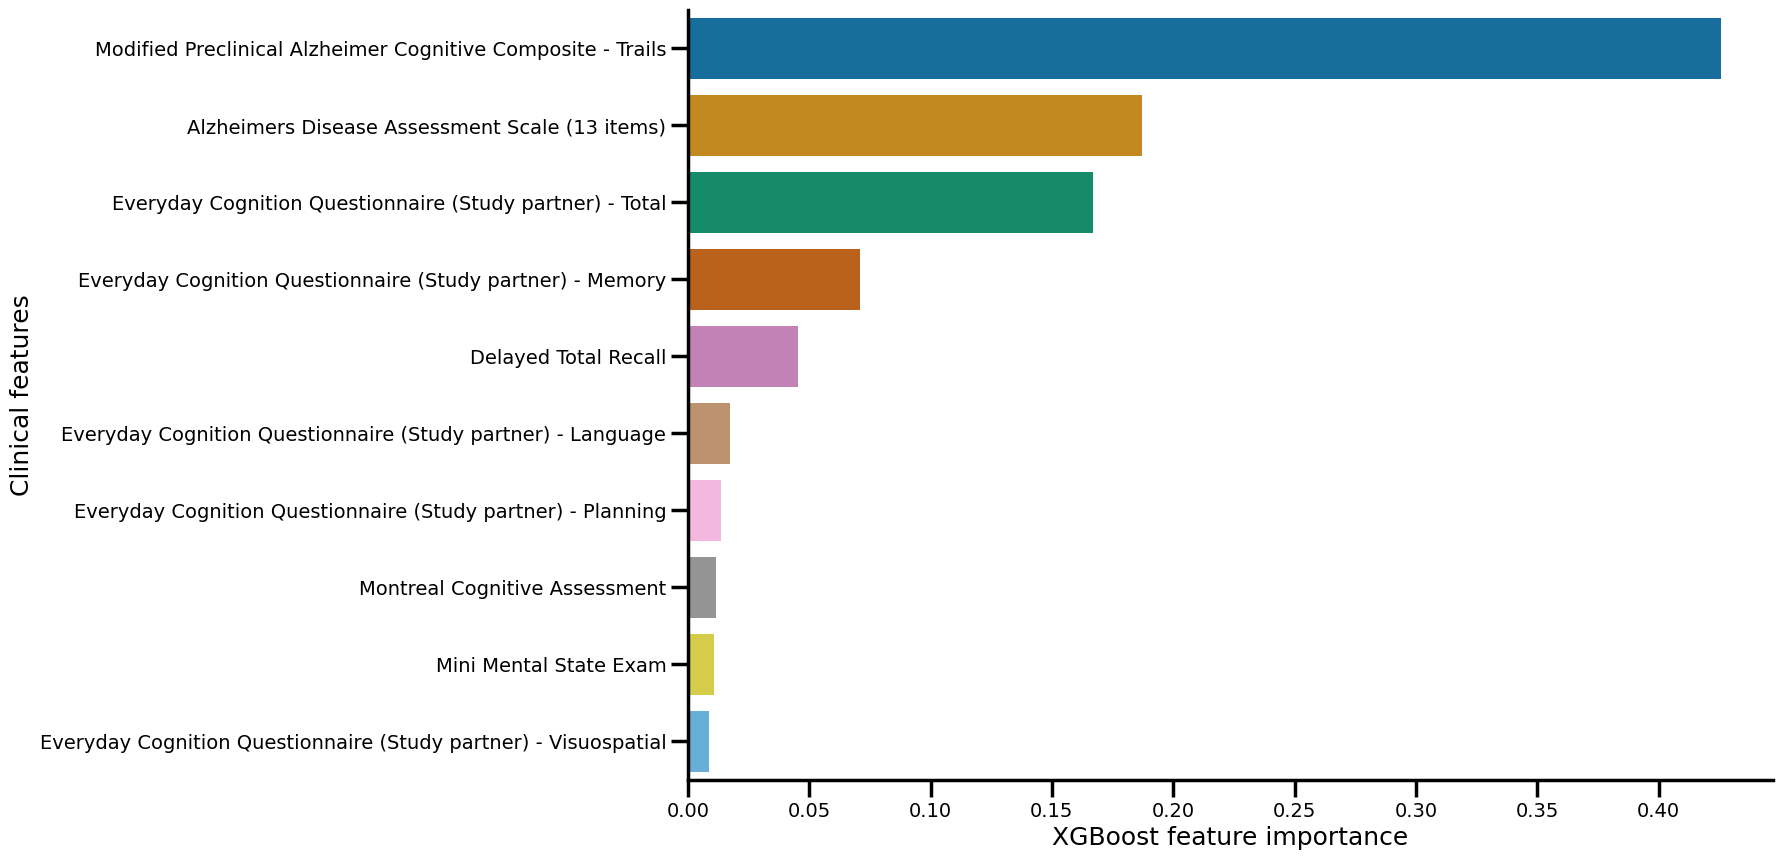

selected feature (s): ['Modified Preclinical Alzheimer Cognitive Composite - Trails']
100-round fivefold stratified cross validation:
Training: 0.979 ± 0.007; Validation: 0.957 ± 0.035
selected feature (s): ['Modified Preclinical Alzheimer Cognitive Composite - Trails'
 'Alzheimers Disease Assessment Scale (13 items)']
100-round fivefold stratified cross validation:
Training: 0.989 ± 0.003; Validation: 0.962 ± 0.028
selected feature (s): ['Modified Preclinical Alzheimer Cognitive Composite - Trails'
 'Alzheimers Disease Assessment Scale (13 items)'
 'Everyday Cognition Questionnaire (Study partner) - Total']
100-round fivefold stratified cross validation:
Training: 0.995 ± 0.005; Validation: 0.975 ± 0.024
selected feature (s): ['Modified Preclinical Alzheimer Cognitive Composite - Trails'
 'Alzheimers Disease Assessment Scale (13 items)'
 'Everyday Cognition Questionnaire (Study partner) - Total'
 'Everyday Cognition Questionnaire (Study partner) - Memory']
100-round fivefold stratifie

In [122]:
# %%time

selected_features, top_10_features = utils.feature_selection(X, y, x_col, y_col, model = model)

# USING THIS: can be erratic even when removing collinear features, an experiment I ran selected the features below
selected_features = ['Everyday Cognition Questionnaire (Study partner) - Total', 'Alzheimers Disease Assessment Scale (13 items)', 'Delayed Total Recall']

## Boosted interpretability model

In [ ]:
model = xgb.XGBClassifier(enable_categorical= True, 
                             objective='binary:logistic', 
                             eval_metric = 'logloss', 
                             tree_method='hist', 
                             n_estimators=1,
                             max_depth = 2, #reduce to improve generalizability, maintained performance
                               )

SEED = 1

X = X[selected_features]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=SEED)
    
model.fit(X,y)

def show_confusion_matrix(validations, predictions, name, save=False):
    LABELS = ['CN','ADD']
    matrix = metrics.confusion_matrix(validations, predictions)
    # plt.figure(dpi=400,figsize=(4.5, 3))
    plt.figure(figsize=(4.5, 3))
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=2,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    if save==True:
        plt.savefig('Figures/' + name +'_xgb_fs.png')
    plt.show()

 #train
pred_train = model.predict(X)
show_confusion_matrix(y, pred_train, 'train')
print(classification_report(y, pred_train))

#validation
pred_val = model.predict(X_val)
show_confusion_matrix(y_val, pred_val, 'valid')
print(classification_report(y_val, pred_val))

plt.figure(dpi=300)
# create_feature_map(selected_features)
plot_tree(model)
# plt.savefig('Figures/plottree.png')
plt.show()

### **Multiple highly accurate representations of this tree can be formed. This iteration of the experiment may not be identical.

# New addition, going deep into grid search

In [139]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna

# Assuming X and y are defined earlier in your script
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Initialize an array to store out-of-fold predictions
train_oof = np.zeros(y.shape[0])

# Define the number of boosting rounds and seed
# num_round = 1000
SEED = 1

def objective(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
        'tree_method': trial.suggest_categorical('tree_method', ['hist']),  # Options: 'gpu_hist', 'hist'
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        #num_estimators = 1
        model = xgb.train(params, dtrain, 1, [(dval, 'eval')], early_stopping_rounds=50, verbose_eval=False)

        predictions = model.predict(dval)
        train_oof[val_index] = predictions

    auc = roc_auc_score(y, train_oof)

    return auc

# Example of running the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params


[I 2023-11-30 13:20:12,909] A new study created in memory with name: no-name-78159646-46bb-48e1-99b6-4d899b1a5fc8
[I 2023-11-30 13:20:12,939] Trial 0 finished with value: 0.497736256664828 and parameters: {'objective': 'binary:logistic', 'tree_method': 'hist', 'lambda': 0.0035104361352934757, 'alpha': 1.162898938003446, 'gamma': 0.00173633235910106, 'colsample_bytree': 0.7688295995725719, 'subsample': 0.9082456672561062, 'learning_rate': 0.0013454555815889298, 'max_depth': 3, 'min_child_weight': 233, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.497736256664828.
[I 2023-11-30 13:20:12,963] Trial 1 finished with value: 0.7402632224060796 and parameters: {'objective': 'binary:logistic', 'tree_method': 'hist', 'lambda': 0.2744382215250884, 'alpha': 0.02020563333602264, 'gamma': 0.02597774715759341, 'colsample_bytree': 0.5286537547421467, 'subsample': 0.741896086864468, 'learning_rate': 0.0548962854907515, 'max_depth': 4, 'min_child_weight': 13, 'eval_metric': 'auc'}. Best is trial 

Best trial:
  Value:  0.8331341545627262
  Params: 
    objective: binary:logistic
    tree_method: hist
    lambda: 0.07523571655982995
    alpha: 0.4766197890325328
    gamma: 0.002505905252148807
    colsample_bytree: 0.6962002929191958
    subsample: 0.9999201748770447
    learning_rate: 0.010162567168327708
    max_depth: 4
    min_child_weight: 9
    eval_metric: auc


## Interpretable prognostic model after deep grid search

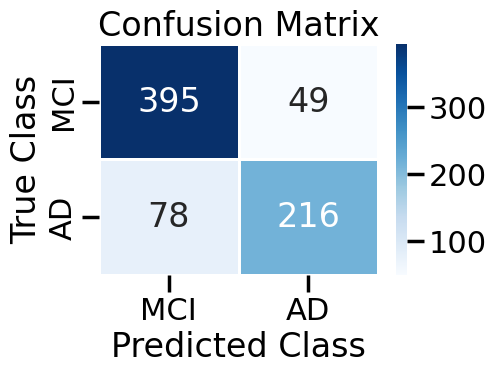

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       444
           1       0.82      0.73      0.77       294

    accuracy                           0.83       738
   macro avg       0.83      0.81      0.82       738
weighted avg       0.83      0.83      0.83       738



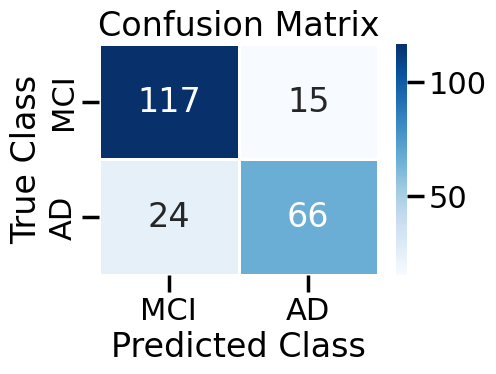

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       132
           1       0.81      0.73      0.77        90

    accuracy                           0.82       222
   macro avg       0.82      0.81      0.81       222
weighted avg       0.82      0.82      0.82       222



<Figure size 1920x1440 with 0 Axes>

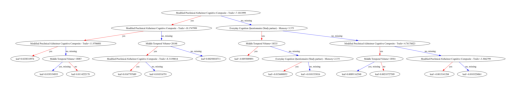

In [140]:
SEED = 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.XGBClassifier(**best_params)

model.fit(X,y)

def show_confusion_matrix(validations, predictions, name, save=False):
    LABELS = ['MCI','AD']
    matrix = metrics.confusion_matrix(validations, predictions)
    # plt.figure(dpi=400,figsize=(4.5, 3))
    plt.figure(figsize=(4.5, 3))
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=2,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    if save==True:
        plt.savefig('Figures/' + name +'_xgb_fs.png')
    plt.show()

 #train
pred_train = model.predict(X)
show_confusion_matrix(y, pred_train, 'train')
print(classification_report(y, pred_train))

#validation
pred_val = model.predict(X_val)
show_confusion_matrix(y_val, pred_val, 'valid')
print(classification_report(y_val, pred_val))

plt.figure(dpi=300)
# create_feature_map(selected_features)
plot_tree(model)
# plt.savefig('Figures/plottree.png')
plt.show()